# Extraction of Regesta data from PDF files as tables.

In [2]:
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## FUNCTIONS

### Preprocessing
Prepares the visualisation of the position of content and text.
The page content is extracted as dictionary/JSON (see <https://pymupdf.readthedocs.io/en/latest/app1.html#dict-or-json>) 

In [5]:
# takes the path to the PDF file and the specified page range
# returns the page content and a DataFrame with the bbox coordinates for all blocks and lines
def preprocessing(path, pages):
    doc = fitz.open(path)
    
    # prepare lists to store content
    contents = []
    positional_data = []
    
    # for each page in the given page range:
    for page_num in range(pages[0] - 1, min(pages[1], len(doc))):
        page = doc.load_page(page_num)
        
        # add the content dictionary and page number to the contents list
        content = page.get_text("dict")
        content['page'] = page_num
        contents.append(content)
        
        # for each block on a page:       
        for block in content.get("blocks", []):
            b_bbox = block['bbox']
            
            # categorise the bbox coordinates of the block based on whether it is on an a- (even) or b- (uneven) page.
            if page_num % 2 == 0:
                positional_data.append((*b_bbox, 'ba', page_num))
            else:
                positional_data.append((*b_bbox, 'bb', page_num))
            positional_data.append((*b_bbox, 'b', page_num))
            
            # for each line in a block:
            for line in block.get("lines", []):
                line_bbox = line['bbox']
                
                # categorise the bbox coordinates of the line based on whether it is on an a- or b-page.
                if page_num % 2 == 0:
                    positional_data.append((*line_bbox, 'la', page_num))
                else:
                    positional_data.append((*line_bbox, 'lb', page_num))
                positional_data.append((*line_bbox, 'l', page_num))

    # create bbox DataFrame
    bbox_df = pd.DataFrame(positional_data, columns=['x0', 'y0', 'x1', 'y1', 'type', 'page'])

    return contents, bbox_df

### Plot
Plots the coordinates of blocks or lines

In [7]:
# takes the DataFrame with the coordinates of each block and line per page
# shows three scatter plots 
def plot_coordinates(df):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # plot bbox upper left coordinates (x0, y0)
    axs[0].scatter(df['x0'], df['y0'], color='red')
    axs[0].set_title('(x0, y0)')
    axs[0].set_xlabel('x0')
    axs[0].set_ylabel('y0')

    # plot bbox lower right coordinates (x1, y1)
    axs[1].scatter(df['x1'], df['y1'], color='blue')
    axs[1].set_title('(x1, y1)')
    axs[1].set_xlabel('x1')
    axs[1].set_ylabel('y1')

    # plot bbox midpoints ((x0+x1)/2, (y0+y1)/2)
    axs[2].scatter((df['x0'] + df['x1']) / 2, (df['y0'] + df['y1']) / 2, color='green')
    axs[2].set_title('((x0+x1)/2, (y0+y1)/2)')
    axs[2].set_xlabel('(x0+x1)/2')
    axs[2].set_ylabel('(y0+y1)/2')

    # invert y-axis to reproduce page layout
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

### Classify lines
Rule-based classification of individual lines; the page structure allows a hierarchical approach.

In [9]:
# takes the bbox coordinates of each line, information about the previous line, and the page region parameters
# returns a classification for the given line
def classify_line(l_data, parameter):
    
    # to improve readability, the coordinates and calculations are stored in variables
    x0, y0, x1, y1 = l_data['l_bbox']
    x_center = (x0 + x1) / 2
    y_center = (y0 + y1) / 2
    width = x1 - x0
    
    if y_center < parameter['header_border'] and parameter['left_pagenumber_border'] < x_center < parameter['right_pagenumber_border']:
        return 'header'
    elif x_center < parameter['left_pagenumber_border'] and (y_center < parameter['header_border'] or y_center > parameter['footer_border']):    # left standing page number
        return 'a-page'
    elif x_center > parameter['right_pagenumber_border'] and (y_center < parameter['header_border'] or y_center > parameter['footer_border']):   # right standing page number
        return 'b-page'
    elif y_center > parameter['footer_border']:
        return 'footer'
    elif width < parameter['number_width'] and l_data['previous_line_end'] == 0 and parameter['mid_strip_start'] < x_center < parameter['mid_strip_end']:
        return 'c-Regestennummer'
    elif ((x0 - l_data['previous_line_end'] > 40) or (abs(l_data['previous_line_y'][0] - y0) > 10)) and (parameter['date_strip_start'] < x_center < parameter['date_strip_end']):
        return 'date'
    else:
        return 'other'

### Extract data
Main function to extract data

In [11]:
# takes the page contents extracted by preprocessing() and the manually defined page region parameters
# returns a classification for each text part
def extract_data(content, parameter):
    
    # prepare lists to store text and category
    classified_text = []
    previous_category = None
    previous_text = []
    # prepare counters for occurences of italic and regular spans inside a block
    i_count = 0
    r_count = 0
    
    # for each block:
    for block in content.get("blocks", []):
#        print("Block")
        
        # prepare variables to check relation between lines inside a block
        previous_line_y = (0,0)
        previous_line_end = 0
        
        # for each line:
        for line in block.get("lines", []):
            # store position data of the current line and transfer the data stored for the previous line
            l_data = {
                'l_bbox': line['bbox'],
                'previous_line_y': previous_line_y,
                'previous_line_end': previous_line_end
            }
            
            # combine the text of all the spans of the line
            l_text = ''.join(span['text'] for span in line.get("spans", []))
            
            # count the italic and regular spans of the line
            for span in line.get('spans', []):
                if ('Italic' or 'italic') in span['font']:
                    i_count += 1
                else:
                    r_count += 1
            
            # classify the line
            category = classify_line(l_data, parameter)
            # activate to print this part of the process
#            print ("   ", category, l_text, "i: ", i_count, "r: ", r_count)

            if category:
                # if the current category is different from the previous one or the current line starts within the indented page area:
                if category != previous_category or ((parameter['indentation_start'] < l_data['l_bbox'][0] < parameter['indentation_end']) and previous_line_end == 0):
                    # either save the previous text as 'Regestentext' if it is mainly written in italics
                    if previous_category == 'other' and i_count > r_count:
#                        print("   ", previous_category, previous_text, "i: ", i_count, "r: ", r_count, l_data['l_bbox'][0])
                        classified_text.append({
                            'type': 'e-Regestentext',
                            'value': ' '.join(previous_text)
                        })
                    # or save the previous text with its corresponding category
                    elif previous_category != None:
#                        print("   ", previous_category, previous_text, "i: ", i_count, "r: ", r_count, l_data['l_bbox'][0])
                        classified_text.append({
                            'type': previous_category,
                            'value': ' '.join(previous_text)
                        })
                        
                    # set the current text and category as new reference values
                    previous_category = category
                    previous_text = [l_text]
                    # reset the counters for italic and regular text
                    i_count = 0
                    r_count = 0
                    
                # if the current category is the same as the previous category, append the text to the previously saved text
                else:
#                    print("   ", previous_category, previous_text, "i: ", i_count, "r: ", r_count, l_data['l_bbox'][0])
                    previous_text.append(l_text)
            
            # set the current x- and y-position as new reference values
            previous_line_end = l_data['l_bbox'][2]
            previous_line_y = (l_data['l_bbox'][1], l_data['l_bbox'][3])
            
    # save the last stored text and its category
    if previous_category:
        classified_text.append({
            'type': previous_category,
            'value': ' '.join(previous_text)
        })

    return classified_text

## INPUT PDF-DATA

In [13]:
# input path to PDF and page range
path = 'PUU_in_Frankreich_NF_1_Champagne_II_Markiert.pdf'
pages = (104, 114)
contents, bbox_df = preprocessing(path, pages)

### Comparative data
If necessary: to quickly load an already known example

In [15]:
# add test data to simplify the search for errors
t_path = 'PUU_in_Frankreich_NF_2_Normandie_Markiert.pdf'
t_pages = (194, 205)
t_contents, t_bbox_df = preprocessing(t_path, t_pages)

t_parameter_a = {
    'header_border' : 135,               # everything above
    'footer_border' : 800,               # everything below
    
    'left_pagenumber_border' : 200,      # everything left to (to exclude set to 0)
    'right_pagenumber_border' : 460,     # everything right to (to exclude set to a value greater than the page width)

    'indentation_start' : 128,           # everything between start and end
    'indentation_end' : 146,
    
    'mid_strip_start' : 300,             # everything between start and end
    'mid_strip_end' : 350,

    'date_strip_start' : 390,            # everything between start and end
    'date_strip_end' : 470,
    
    'number_width' : 30                  # maximal width of a regesta number
}

t_parameter_b = {
    'header_border' : 150,               # everything above
    'footer_border' : 800,               # everything below
    
    'left_pagenumber_border' : 0,        # everything left to (to exclude set to 0)
    'right_pagenumber_border' : 400,     # everything right to (to exclude set to a value greater than the page width)
    
    'indentation_start' : 165,           # everything between start and end
    'indentation_end' : 185,
    
    'mid_strip_start' : 250,             # everything between start and end
    'mid_strip_end' : 300,
    
    'date_strip_start' : 343,            # everything between start and end
    'date_strip_end' : 427,
    
    'number_width' : 30                  # maximal width of a regesta number
}

## Explore an unknown pdf file

### Content Overview

In [18]:
# quick overview of central dimensions for a bbox (insert coordinates manually)
test_box = (262.7601013183594, 223.137451171875, 412.09759521484375, 234.211669921875)
print('width:  ', test_box[2]-test_box[0])
print('height: ', test_box[3]-test_box[1])
print('x-center: ', (test_box[0]+test_box[2]) / 2)
print('y-center: ', (test_box[1]+test_box[3]) / 2)


width:   149.33749389648438
height:  11.07421875
x-center:  337.42884826660156
y-center:  228.674560546875


In [19]:
# overview of page content, block by block
    # if necessary, specify which blocks should be extracted so that, for example, image files are not displayed
    # e.g. starting from the 2nd block:     .get('blocks', [])[1:]
    # or everything except the last block:  .get('blocks', [])[:-1]

content = contents[0]
for block in content.get("blocks", [])[1:-1]:
        print(block)

{'number': 1, 'type': 0, 'bbox': (151.36000061035156, 128.87997436523438, 359.0074157714844, 142.219970703125), 'lines': [{'spans': [{'size': 9.949873924255371, 'flags': 4, 'font': 'PalatinoLinotype-Roman', 'color': 0, 'ascender': 1.0529999732971191, 'descender': -0.2809999883174896, 'text': '276 ', 'origin': (151.36000061035156, 139.40997314453125), 'bbox': (151.36000061035156, 128.87997436523438, 169.14634704589844, 142.219970703125)}], 'wmode': 0, 'dir': (1.0, 0.0), 'bbox': (151.36000061035156, 128.87997436523438, 169.14634704589844, 142.219970703125)}, {'spans': [{'size': 7.661403179168701, 'flags': 4, 'font': 'TimesNewRomanPSMT', 'color': 0, 'ascender': 1.0529999732971191, 'descender': -0.2809999883174896, 'text': 'Urkunden und lîegesten. ', 'origin': (263.20001220703125, 137.72998046875), 'bbox': (263.20001220703125, 129.62188720703125, 359.0074157714844, 139.8936767578125)}], 'wmode': 0, 'dir': (1.0, 0.0), 'bbox': (263.20001220703125, 129.62188720703125, 359.0074157714844, 139.8

In [20]:
# overview of page content per line. If necessary, adjust the number of pages or blocks displayed here
for content in contents[0:5]:
    for block in content.get("blocks", [])[:-1]:
        for line in block.get("lines", []):            
            s_text = ''
            
            for span in line.get("spans", []):
                s_text += span['text']
            print(line['bbox'], '    ', s_text)    

(151.36000061035156, 128.87997436523438, 169.14634704589844, 142.219970703125)      276 
(263.20001220703125, 129.62188720703125, 359.0074157714844, 139.8936767578125)      Urkunden und lîegesten. 
(151.83999633789062, 148.07998657226562, 334.0039978027344, 161.41998291015625)      eius suis quibusque finibus applicare. 
(342.8793640136719, 148.07998657226562, 469.66259765625, 161.41998291015625)      Quam eorum querimoniam 
(151.60000610351562, 160.55996704101562, 467.2357482910156, 173.89996337890625)      ad sinodum referentes et subtiliter inuestigantes testimonio mul-
(151.60000610351562, 173.03994750976562, 469.74884033203125, 186.37994384765625)      torum tam clericorum quam laicorum, qui antiquiores uidebantur, 
(151.60000610351562, 185.51998901367188, 467.23529052734375, 198.8599853515625)      repperimus predictam basilicam sub titulo matricis ecclesie anti-
(151.83999633789062, 197.99996948242188, 247.5, 211.3399658203125)      quitus consecratam. 
(258.6404724121094, 197.9

### Visualisation

In [22]:
bbox_df

,x0,y0,x1,y1,type,page
0,94.000000,84.209961,500.559998,759.089966,bb,103
1,94.000000,84.209961,500.559998,759.089966,b,103
2,151.360001,128.879974,359.007416,142.219971,bb,103
3,151.360001,128.879974,359.007416,142.219971,b,103
4,151.360001,128.879974,169.146347,142.219971,lb,103
...,...,...,...,...,...,...
1625,292.399994,626.679932,334.818787,640.019958,b,113
1626,292.399994,626.679932,334.818787,640.019958,lb,113
1627,292.399994,626.679932,334.818787,640.019958,l,113
1628,92.000000,82.809937,502.399994,760.089966,bb,113


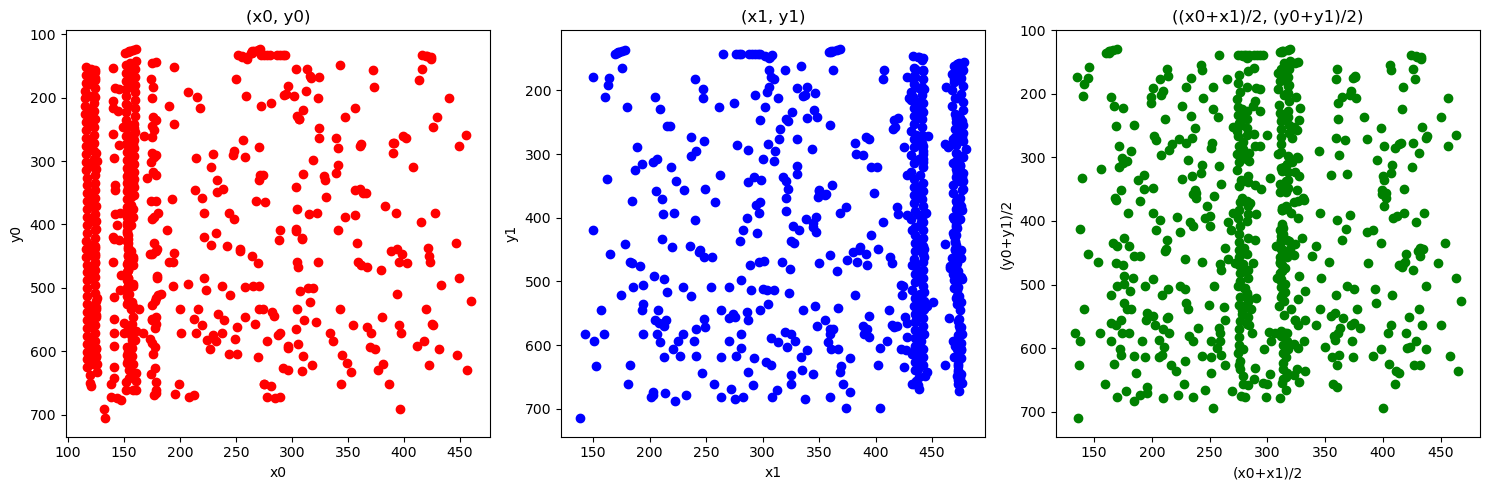

In [23]:
# adjust input to display: type == b for blocks, l for lines, ba or la and bb or lb for even and odd pages
vdf = bbox_df[bbox_df['type']=='l']

# prepared filter options to view headers and footers more precisely. Activate one of the following lines to filter out or comment out everything in order to display the complete plot
#vdf = vdf[vdf['y1'] < 200]       # Header
#vdf = vdf[vdf['y1'] > 680]       # Footer
#vdf = vdf[vdf['x0'] < 200]       # indentation

#vdf = vdf[(vdf['page'] == 215)]  # single page
#vdf = vdf[(vdf['y1'] < 200) & (vdf['page'] == 215)]       # Header and page
#vdf = vdf[(vdf['y1'] > 600) & (vdf['page'] == 215)]       # Footer and page

plot_coordinates(vdf)

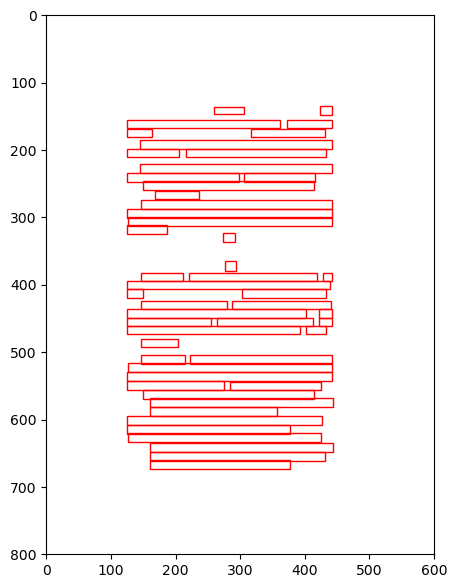

In [24]:
# takes the previous (maybe already prefiltered) DataFrame
# shows each block or line as box
rect_df = vdf

# activate one of the following lines to specify page or page range
rect_df = vdf[vdf['page']==104]
#rect_df = vdf[(216 < vdf['page']) & (vdf['page'] < 230)]

fig, ax = plt.subplots(figsize=(5,7))

for index, row in rect_df.iterrows():
    rect = patches.Rectangle(
        (row.iloc[0], row.iloc[1]), # (x, y)
        row.iloc[2] - row.iloc[0],  # width
        row.iloc[3] - row.iloc[1],  # height
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

ax.set_xlim(0, 600)
ax.set_ylim(0, 800)

ax.invert_yaxis()
plt.show()
    

## SET PAGE REGION LIMITS
Use the plots to define boundaries for page regions on even (a) and odd (b) pages

In [26]:
# a = even page number
# b = odd page number

parameter_a = {
    'header_border' : 150,               # everything above
    'footer_border' : 800,               # everything below
    
    'left_pagenumber_border' : 200,      # everything left to (to exclude set to 0)
    'right_pagenumber_border' : 400,     # everything right to (to exclude set to a value greater than the page width)

    'indentation_start' : 130,           # everything between start and end
    'indentation_end' : 155,
    
    'mid_strip_start' : 240,             # everything between start and end
    'mid_strip_end' : 350,

    'date_strip_start' : 343,            # everything between start and end
    'date_strip_end' : 427,
    
    'number_width' : 30                  # maximal width of a regesta number
}

parameter_b = {
    'header_border' : 150,               # everything above
    'footer_border' : 800,               # everything below
    
    'left_pagenumber_border' : 200,        # everything left to (to exclude set to 0)
    'right_pagenumber_border' : 400,     # everything right to (to exclude set to a value greater than the page width)
    
    'indentation_start' : 170,           # everything between start and end
    'indentation_end' : 195,
    
    'mid_strip_start' : 240,             # everything between start and end
    'mid_strip_end' : 350,
    
    'date_strip_start' : 343,            # everything between start and end
    'date_strip_end' : 427,
    
    'number_width' : 30                  # maximal width of a regesta number
}

## MAIN - EXTRACT DATA

### Classify text

In [29]:
# takes the page contents extracted by preprocessing() and passes it together with the manually defined parameters depending on whether the page is even or odd
# returns the text parts and their classification
classified_texts = []

for content in contents:
    if (content['page'] % 2) == 0:
        classified_texts.append(extract_data(content, parameter_a))
    else:
        classified_texts.append(extract_data(content, parameter_b))
for text in classified_texts:
    print(text)

[{'type': 'a-page', 'value': '276 '}, {'type': 'header', 'value': 'Urkunden und lîegesten. '}, {'type': 'other', 'value': "eius suis quibusque finibus applicare.  Quam eorum querimoniam  ad sinodum referentes et subtiliter inuestigantes testimonio mul- torum tam clericorum quam laicorum, qui antiquiores uidebantur,  repperimus predictam basilicam sub titulo matricis ecclesie anti- quitus consecratam.  Qui etiam cum sacramento probauerunt se  ueraciter scire ipsam parrocbiam infra suburbium a priscis tempo- ribus ita determinatam, ut a muris urbis et porta australiatque  a fluuiolo Angrusia, qui medium suburbium interluit, quicquid hac  meta concluditur usque ad summum uicem sancti Apri predicte  matrici ecclesie more parrochiali sine preiudicio fore subiectum, ea  tarnen lege ut, si ipsi parrochiani de terra sancti Stephani aliquid  extra prefinitum terminum excolerent, ad titulum sancti Iohannis  debitam decimationem redderent.  Extra suburbium quia legitime  determinationes definiri 

### Sort text into regesta

In [31]:
# takes the classified text parts and assigns them to the corresponding Regestennummer
# returns the sorted regesta

# prepare variables 
regesta = []
current_regest = {}

# counter whose value can be added to a category to allow multiple entries of this category within the same Regest
k = 10

# for each regest:
for text in classified_texts:
    for item in text:
        
        # create a new dictionary, if the current item is classified as Regestennummer
        if item['type'] == "c-Regestennummer":
            if current_regest:
                regesta.append(current_regest)
            current_regest = {"c-Regestennummer": item['value']}
            k = 10
        # or append the current item to the current dictionary
        else:
            key = item['type']
            # directly or with a changed key (+k) to allow multiple entries of the current category within the same Regest
            if key in current_regest:
                key1 = key + f'{k}'
                current_regest[key1] = item['value']
                k += 1
            else:
                current_regest[item['type']] = item['value']
            
# add the last stored text and its category
if current_regest:
    regesta.append(current_regest)

for regest in regesta:
    print(regest)

{'a-page': '276 ', 'header': 'Urkunden und lîegesten. ', 'other': "eius suis quibusque finibus applicare.  Quam eorum querimoniam  ad sinodum referentes et subtiliter inuestigantes testimonio mul- torum tam clericorum quam laicorum, qui antiquiores uidebantur,  repperimus predictam basilicam sub titulo matricis ecclesie anti- quitus consecratam.  Qui etiam cum sacramento probauerunt se  ueraciter scire ipsam parrocbiam infra suburbium a priscis tempo- ribus ita determinatam, ut a muris urbis et porta australiatque  a fluuiolo Angrusia, qui medium suburbium interluit, quicquid hac  meta concluditur usque ad summum uicem sancti Apri predicte  matrici ecclesie more parrochiali sine preiudicio fore subiectum, ea  tarnen lege ut, si ipsi parrochiani de terra sancti Stephani aliquid  extra prefinitum terminum excolerent, ad titulum sancti Iohannis  debitam decimationem redderent.  Extra suburbium quia legitime  determinationes definiri non poterant, ubicumque sua perueniret  pars, sine contr

### Postprocessing


In [33]:
# show regesta as table (DataFrame)
export_df = pd.DataFrame(regesta)
s_export_df = export_df.sort_index(axis=1)

s_export_df

,a-page,b-page,c-Regestennummer,date,e-Regestentext,e-Regestentext10,e-Regestentext11,e-Regestentext18,header,header16,other,other10,other11,other12,other13,other14,other15,other17
0,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urkunden und lîegesten.,NaN,eius suis quibusque finibus applicare. Quam e...,a) astrali. b) percipiat. c) inueniat.,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,277,81.,Praeneste 1161 Juni 28.,"Alexander III. nimmt nach, dem Vorgange Innoc...","bis zum Sonnabend abend, das Pfarrbesetzungsre...",Or. H 3 Châlons-sur-Marne Arch. dép. (vgl. H 2...,NaN,Nr. 101—105.,NaN,1) J.-L. 7454.,NaN,NaN,Alexander etc. Dilecto fìlio Iuoni abbati eccl...,Dat. Prenest. per manum Hermanni sancte ßomane...,NaN,NaN,NaN
2,278,NaN,(B.) 82.,Terracina 1161 Dezember 9.,Alexander III. erneut das von seinem Vorgänge...,Or. H 212 Châlons-sur-Marne Arch. dép. — Kop....,NaN,NaN,Urkunden und lîegesten.,NaN,Vgl. Nr. 77.,NaN,Alexander etc. Dilectis fìliis Iacobo abbati ...,Dat. Terracine per manum Hermanni sancte Roman...,NaN,NaN,NaN,NaN
3,NaN,NaN,83.,(er. 1160—62).,Kardinallegat Heinrich von S. Nereus und Achil...,Kop. s. XII im Cartul. de Cheminon f. 37 Châl...,Wegen der zeitlichen Einordnung vgl. W. Ohnsor...,NaN,NaN,NaN,Contrahencium uoluntates scripturarum stabilit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,279,84.,Tours 1162 November 9.,Alexander III. nimmt das Kloster S. Memmie be...,NaN,NaN,NaN,Nr. 101—105.,NaN,Kop. s. XVI11 Coll. de Champagne 38 f. 130 Par...,Alexander etc. Dilecto fìlio Iuoni abbati sanc...,Datum Turonis per manum Theodorici sante Roman...,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,85.,Tours 1162 November 26.,Alexander III. nimmt das Kloster Auberive in ...,Or. H 8 n. 2 Chaumont Arch. dép. — Kop. von 17...,NaN,NaN,NaN,NaN,Alexander etc. Rainerio abbati monasterii Albe...,NaN,Dat. Turonis p. m. Hermanni sancte Romane eccl...,NaN,NaN,NaN,NaN,NaN
6,280,NaN,(B.) 86.,Paris 1163 Februar 6.,Alexander III. nimmt das Kloster Cheminon in S...,Or. im Fonds de Cheminon Châlons-sur-Marne A...,NaN,NaN,Urkunden und lîegesten.,NaN,Alexander etc. Hugoni abbati monasterii sancte...,NaN,"Dat. Paris, p. m. Hermanni sancte Romane eccle...",NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,87.,Paris 1163 Februar 9.,Alexander III. nimmt das Kloster Signy in Schu...,Kop. s. XIII im Cartulaire de Signy f. 2 Mézi...,NaN,NaN,NaN,NaN,Alexander etc. Alardo abbati monasterii de Sig...,NaN,Dat. Parisius p. m. Hermanni sancte Romane ecc...,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,88.,Paris 1163 April 20.,Alexander III. nimmt das Kloster Beaupré in ...,Or. H 328 n. 2 Nancy Arch. díp. — Kop. s. XVII...,NaN,NaN,NaN,NaN,Alexander etc. Lanberto abbati de Bello Prato ...,NaN,Dat. Parisius p. m. Hermanni sanet^ Romano ecc...,NaN,NaN,NaN,NaN,NaN
9,NaN,281,89.,Sens 1163 Oktober 12.,"recht, das Verbot des Wiederausscheidens und ...",NaN,NaN,NaN,Nr. 101—105.,NaN,Alexander III. nimmt das Cisterzienserkloster ...,"Or., schlecht erhalten, 6 H Liasse 1 Ghaumont ...",Alexander etc. Radulfo abbati monasterii Long...,Dat. Senonis p. m. Hermanni sancte Romane eccl...,NaN,NaN,NaN,NaN


In [34]:
# group page numbers in one column
seite_columns = [col for col in s_export_df if 'page' in col]
s_export_df['Seitenbereich'] = s_export_df[seite_columns].astype(str).apply(lambda row: sorted(row.values), axis=1)
s_export_df.drop(columns=seite_columns, inplace=True)
s_export_df['Seitenbereich'] = s_export_df['Seitenbereich'].apply(lambda x: [i for i in x if i != 'nan'])
s_export_df

,c-Regestennummer,date,e-Regestentext,e-Regestentext10,e-Regestentext11,e-Regestentext18,header,header16,other,other10,other11,other12,other13,other14,other15,other17,Seitenbereich
0,NaN,NaN,NaN,NaN,NaN,NaN,Urkunden und lîegesten.,NaN,eius suis quibusque finibus applicare. Quam e...,a) astrali. b) percipiat. c) inueniat.,NaN,NaN,NaN,NaN,NaN,NaN,[276 ]
1,81.,Praeneste 1161 Juni 28.,"Alexander III. nimmt nach, dem Vorgange Innoc...","bis zum Sonnabend abend, das Pfarrbesetzungsre...",Or. H 3 Châlons-sur-Marne Arch. dép. (vgl. H 2...,NaN,Nr. 101—105.,NaN,1) J.-L. 7454.,NaN,NaN,Alexander etc. Dilecto fìlio Iuoni abbati eccl...,Dat. Prenest. per manum Hermanni sancte ßomane...,NaN,NaN,NaN,[277 ]
2,(B.) 82.,Terracina 1161 Dezember 9.,Alexander III. erneut das von seinem Vorgänge...,Or. H 212 Châlons-sur-Marne Arch. dép. — Kop....,NaN,NaN,Urkunden und lîegesten.,NaN,Vgl. Nr. 77.,NaN,Alexander etc. Dilectis fìliis Iacobo abbati ...,Dat. Terracine per manum Hermanni sancte Roman...,NaN,NaN,NaN,NaN,[278 ]
3,83.,(er. 1160—62).,Kardinallegat Heinrich von S. Nereus und Achil...,Kop. s. XII im Cartul. de Cheminon f. 37 Châl...,Wegen der zeitlichen Einordnung vgl. W. Ohnsor...,NaN,NaN,NaN,Contrahencium uoluntates scripturarum stabilit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,84.,Tours 1162 November 9.,Alexander III. nimmt das Kloster S. Memmie be...,NaN,NaN,NaN,Nr. 101—105.,NaN,Kop. s. XVI11 Coll. de Champagne 38 f. 130 Par...,Alexander etc. Dilecto fìlio Iuoni abbati sanc...,Datum Turonis per manum Theodorici sante Roman...,NaN,NaN,NaN,NaN,NaN,[279 ]
5,85.,Tours 1162 November 26.,Alexander III. nimmt das Kloster Auberive in ...,Or. H 8 n. 2 Chaumont Arch. dép. — Kop. von 17...,NaN,NaN,NaN,NaN,Alexander etc. Rainerio abbati monasterii Albe...,NaN,Dat. Turonis p. m. Hermanni sancte Romane eccl...,NaN,NaN,NaN,NaN,NaN,[]
6,(B.) 86.,Paris 1163 Februar 6.,Alexander III. nimmt das Kloster Cheminon in S...,Or. im Fonds de Cheminon Châlons-sur-Marne A...,NaN,NaN,Urkunden und lîegesten.,NaN,Alexander etc. Hugoni abbati monasterii sancte...,NaN,"Dat. Paris, p. m. Hermanni sancte Romane eccle...",NaN,NaN,NaN,NaN,NaN,[280 ]
7,87.,Paris 1163 Februar 9.,Alexander III. nimmt das Kloster Signy in Schu...,Kop. s. XIII im Cartulaire de Signy f. 2 Mézi...,NaN,NaN,NaN,NaN,Alexander etc. Alardo abbati monasterii de Sig...,NaN,Dat. Parisius p. m. Hermanni sancte Romane ecc...,NaN,NaN,NaN,NaN,NaN,[]
8,88.,Paris 1163 April 20.,Alexander III. nimmt das Kloster Beaupré in ...,Or. H 328 n. 2 Nancy Arch. díp. — Kop. s. XVII...,NaN,NaN,NaN,NaN,Alexander etc. Lanberto abbati de Bello Prato ...,NaN,Dat. Parisius p. m. Hermanni sanet^ Romano ecc...,NaN,NaN,NaN,NaN,NaN,[]
9,89.,Sens 1163 Oktober 12.,"recht, das Verbot des Wiederausscheidens und ...",NaN,NaN,NaN,Nr. 101—105.,NaN,Alexander III. nimmt das Cisterzienserkloster ...,"Or., schlecht erhalten, 6 H Liasse 1 Ghaumont ...",Alexander etc. Radulfo abbati monasterii Long...,Dat. Senonis p. m. Hermanni sancte Romane eccl...,NaN,NaN,NaN,NaN,[281 ]


## EXPORT AS CSV

In [36]:
# show path and page range of the input to manually adjust the name of the output file
print(t_path, '   ', t_pages)

PUU_in_Frankreich_NF_2_Normandie_Markiert.pdf     (194, 205)


In [37]:
s_export_df.to_csv('PUU_in_Frankreich_NF_2_Normandie_Markiert-194-205_Test.csv', index=True)

### Show parameter

In [39]:
print (parameter_a)
print (parameter_b)

{'header_border': 150, 'footer_border': 800, 'left_pagenumber_border': 200, 'right_pagenumber_border': 400, 'indentation_start': 130, 'indentation_end': 155, 'mid_strip_start': 240, 'mid_strip_end': 350, 'date_strip_start': 343, 'date_strip_end': 427, 'number_width': 30}
{'header_border': 150, 'footer_border': 800, 'left_pagenumber_border': 200, 'right_pagenumber_border': 400, 'indentation_start': 170, 'indentation_end': 195, 'mid_strip_start': 240, 'mid_strip_end': 350, 'date_strip_start': 343, 'date_strip_end': 427, 'number_width': 30}
